In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import missingno as msno

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.metrics import roc_auc_score, classification_report, f1_score, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [3]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-u3va7nl2
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-u3va7nl2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/15/c4/1310a054d33abc318426a956e7d6df0df76a6ddfa9c66f6310274fb75d42/pyaml-20.4.0-py2.py3-none-any.whl
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.dev0-cp37-none-any.whl size=102003 sha256=540200b9eb614d1cdfbec71f9ce696669fd72737102ee7ef62a609d1e617f508
  Stored in directory: /tmp/pip-ephem-wheel-cache-l5jyc65o/wheels/11/6f/86/2b772172db85ad0b4487d67e325e535ee8e7782b2a1dfcadf5
Successfully built scikit-optimize


In [4]:
!pip install catboost

     |████████████████████████████████| 65.7MB 86kB/s 


In [5]:
from time import time
import pprint
import joblib

# Classifiers
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

In [6]:
cd /content/drive/MyDrive/Hackathon /Health Insurance Lead Prediction

/content/drive/MyDrive/Hackathon /Health Insurance Lead Prediction


In [7]:
data = pd.read_csv("train_Df64byy.csv")
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [8]:
test_data = pd.read_csv('test_YCcRUnU.csv')
test_data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [9]:
data.shape # shape of the dataset

(50882, 14)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

Datatypes of the following columns are incorrect:
- Region_Code
- Holding_Policy_Type
- Reco_Policy_Cat

Needs to be of **object** or **categorical**

In [11]:
# change datatype of the above columns
cols = ['Region_Code', 'Holding_Policy_Type', 'Reco_Policy_Cat']
data[cols] = data[cols].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  object 
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(1), int64(4

In [12]:
data.duplicated().sum() #  check for duplicate observation

0

All observations are unique.

In [13]:
len(data['ID'].unique())

50882

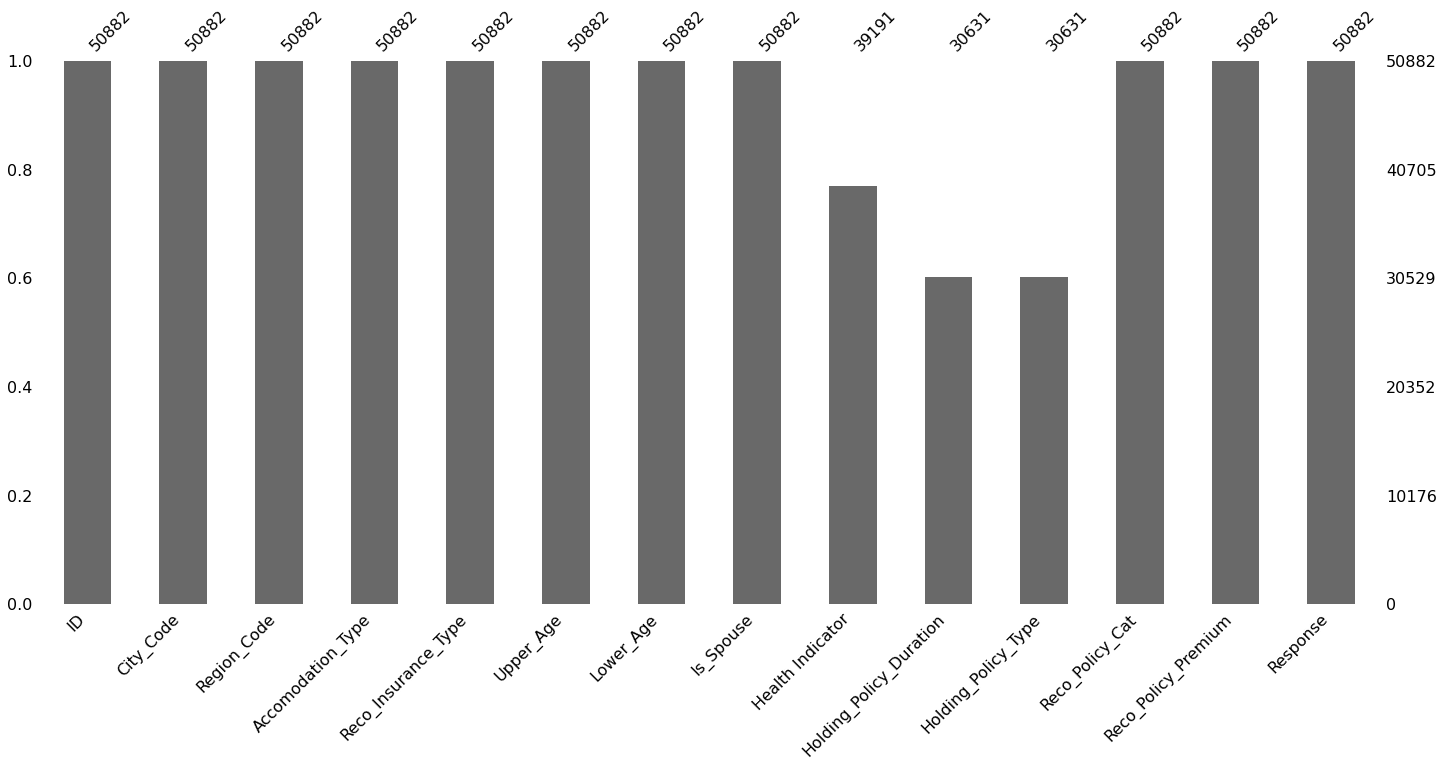

In [14]:
msno.bar(data)

Presence of missing values in following columns:
- Health Indicator
- Holding Policy Duration
- Holding policy type

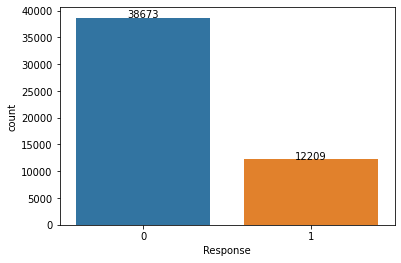

In [15]:
graph = sns.countplot('Response', data=data);
graph.set_xticklabels(graph.get_xticklabels())
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        data['Response'].value_counts()[i],ha="center")
    i += 1

Looks like data is **imbalanced**. Proportion of customers who show interest in recommended policy are **12209** out of **50882**. 
- 0 - Customer did not show interest in the recommended policy
- 1 - Customer showed interest in the recommended policy

In [16]:
data['Response'].value_counts(normalize=True)*100

0    76.005267
1    23.994733
Name: Response, dtype: float64

In [ ]:
# some statistical description
data.iloc[:,1:].describe()

,Upper_Age,Lower_Age,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000
mean,44.856275,42.738866,14183.950069,0.239947
std,17.310271,17.319375,6590.074873,0.427055
min,18.000000,16.000000,2280.000000,0.000000
25%,28.000000,27.000000,9248.000000,0.000000
50%,44.000000,40.000000,13178.000000,0.000000
75%,59.000000,57.000000,18096.000000,0.000000
max,75.000000,75.000000,43350.400000,1.000000


### Exploratory data Analysis

In [ ]:
data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1,16,10404.0,0


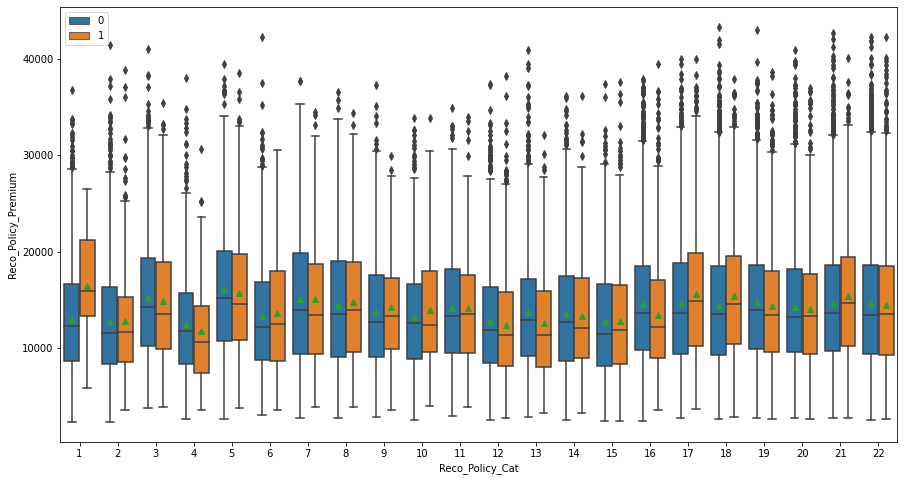

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x = 'Reco_Policy_Cat', y='Reco_Policy_Premium',hue='Response', data= data, showmeans=True)
plt.legend();

**Observation** : There is no any significant median difference for premium of recommended for most of the policy category of any response from customer.

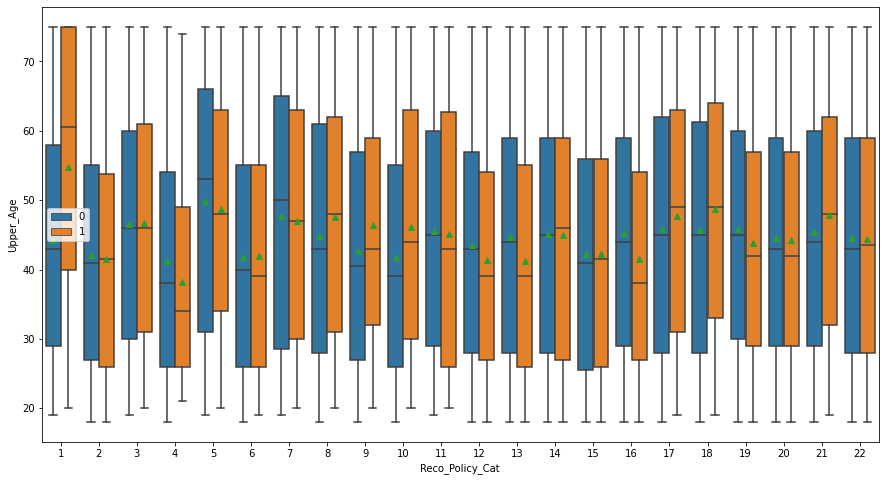

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x = 'Reco_Policy_Cat', y='Upper_Age',hue='Response', data= data, showmeans=True)
plt.legend();

**Observation**: For policy cat, median of upper age  is not significant for some policy categories. Nothing significant respecct to dependent variable.

In [ ]:
len(data['City_Code'].unique())

36

No handles with labels found to put in legend.


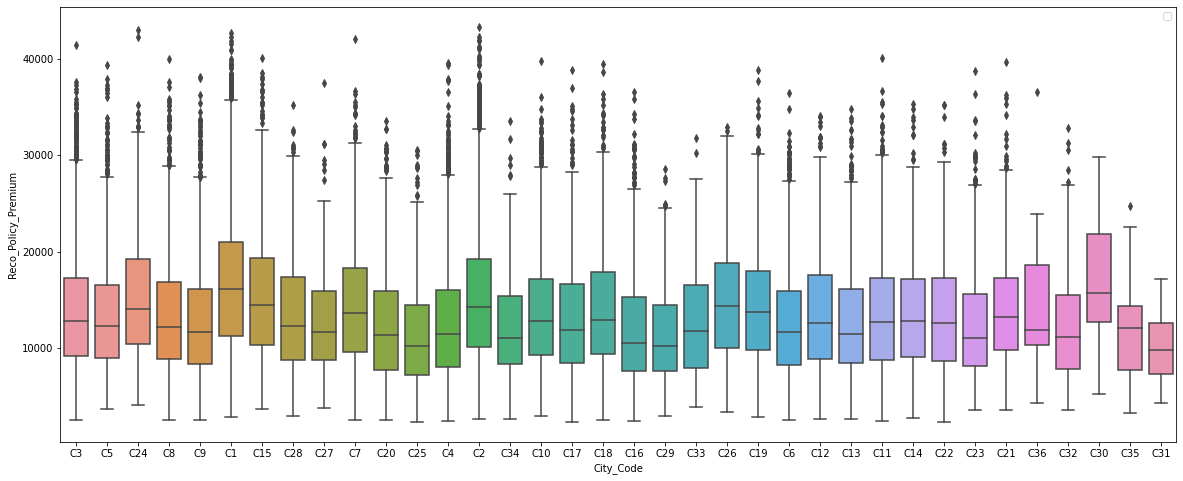

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x ='City_Code', y='Reco_Policy_Premium', data= data,)
plt.legend();

Median of Premium of recommended policy for all city code is looks like same with slight variations above and below of the overall  median.

In [21]:
cat_col=[]
for col in data.columns:
    if data[col].dtype == 'object':
        cat_col.append(col)

cat_col = [x for x in cat_col if x not in ['City_Code', 'Region_Code']]

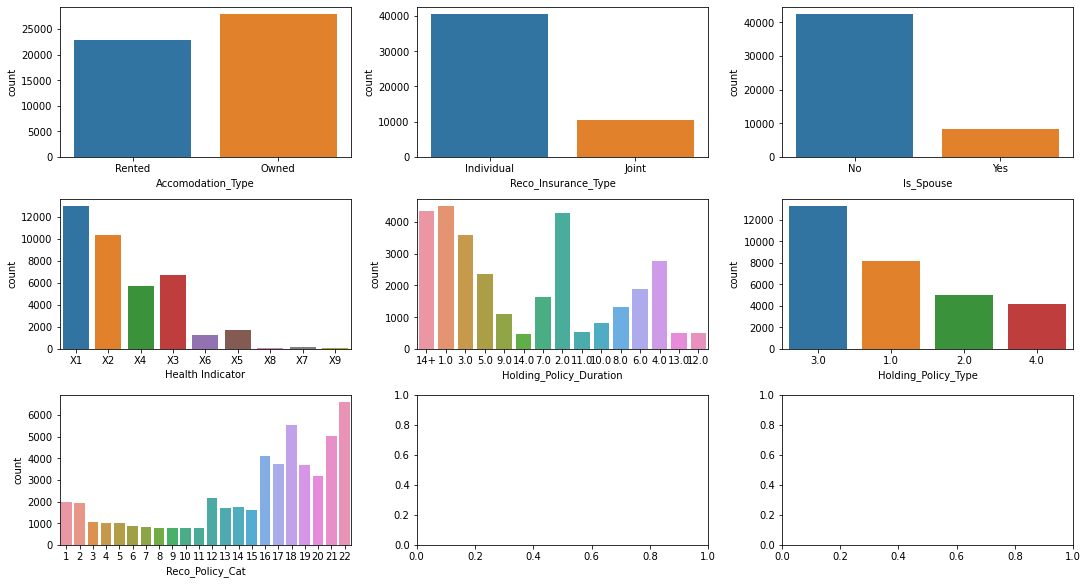

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(15,8), constrained_layout=True)
i=0
for col in cat_col:
    if data[col].dtype == 'object':
        sns.countplot(data[col], ax = ax.flat[i])
        i+=1

Observations:
- majority of customers got individual recommendation.
- majority of the customers are not married
- majority customers belongs X1 and X2 health indicator category
- majority customers holds policy for 1,2,3,4,5 or 14+ years.
- majority of customers holds type 3 policy
- majorty customers got recommendation of policy from 16 to 22 types.

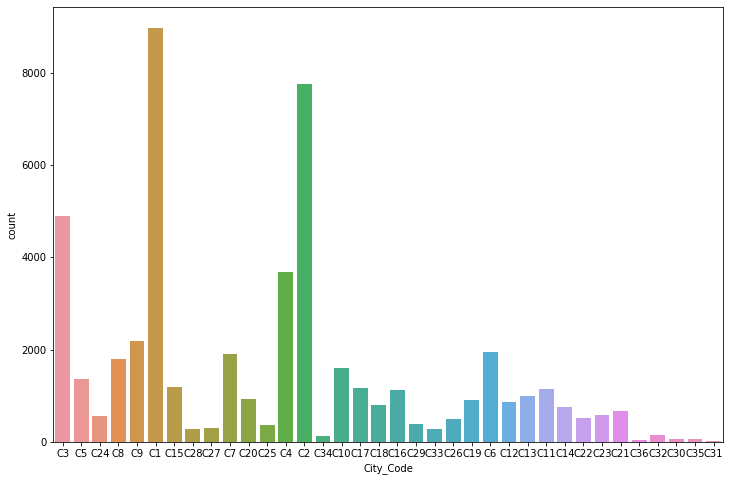

In [24]:
plt.figure(figsize=(12, 8))
sns.countplot(data['City_Code']);

In [36]:
# lets find out continous and categorical columns

continuous_cols = []
cat_cols = []

for i in list(data.columns):
  if (data[i].dtype == 'int64') or (data[i].dtype == 'float64'):
    continuous_cols.append(i)
  else:
    cat_cols.append(i)

continuous_cols.remove('Response')
continuous_cols.remove('ID')

In [37]:
continuous_cols

['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium']

<Figure size 1080x360 with 0 Axes>

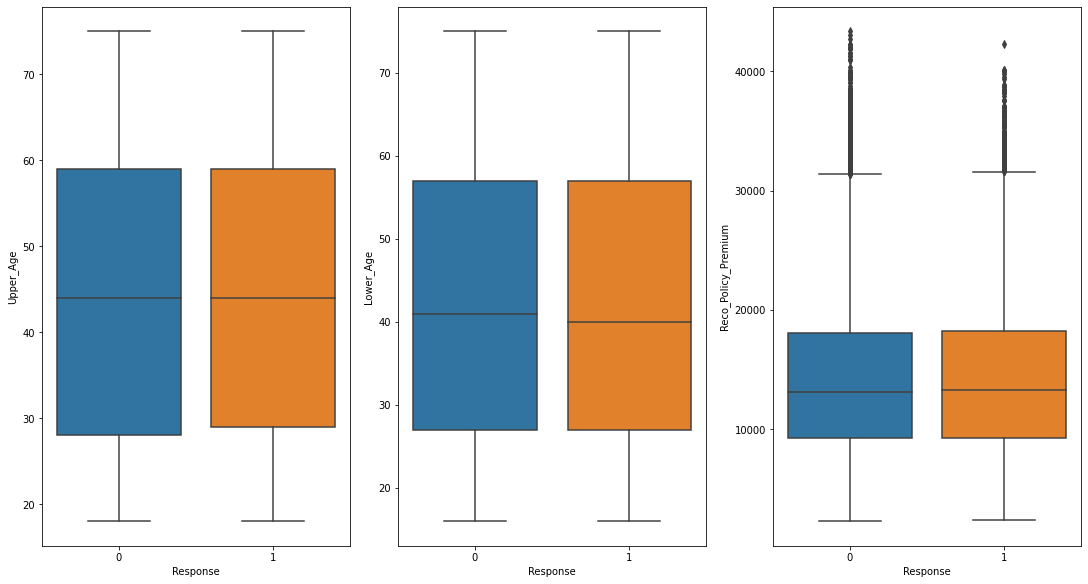

In [39]:
# lets see how individual variables affects on target 

# plotting box plots

plt.figure(figsize=(15,5))
fig, ax = plt.subplots(1, 3, figsize=(15,8), constrained_layout=True)
i=0
for col in continuous_cols:
    sns.boxplot(x= data['Response'], y = data[col], ax = ax.flat[i])
    i+=1

none of the continous variable impacting the target variable. medians for all responses looks same 

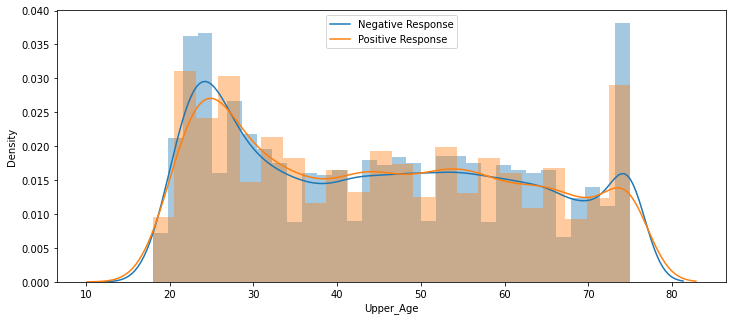

In [40]:
# checking distributions of age wtr. positive and negative response
plt.figure(figsize=(12,5))

sns.distplot(data[data['Response']==0]['Upper_Age'])

sns.distplot(data[data['Response']==1]['Upper_Age'])

plt.legend(['Negative Response', 'Positive Response'])

There is a thin seperation, more of too young and too old customer give negative response

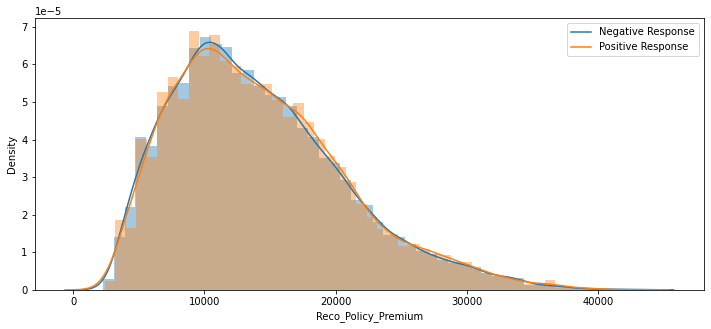

In [41]:
# checking distributions of policy premium amount wtr. positive and negative response

plt.figure(figsize=(12,5))

sns.distplot(data[data['Response']==0]['Reco_Policy_Premium'])

sns.distplot(data[data['Response']==1]['Reco_Policy_Premium'])

plt.legend(['Negative Response', 'Positive Response'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  object 
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(1), int64(4